## 1. Environment setup

In [10]:
import os
os.system('source /Users/sologaes/project/hyper/lalsuite/_inst/etc/lalsimulation-user-env.sh')
import time
import inspect, copy
import numpy as np
from astropy import units as u
from astropy.constants import G, c, M_sun, R_sun, L_sun, au, pc
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
            "font.family": 'serif',
            "font.size": 12,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],
            'axes.unicode_minus': False
         }
rcParams.update(config)

In [12]:
!source /Users/sologaes/project/hyper/lalsuite/_inst/etc/lalsimulation-user-env.sh
import lal, lalsimulation
import pycwb
import pycbc
import pycbc.scheme as _scheme
from pycbc import pnutils
from pycbc.types import TimeSeries, FrequencySeries, zeros, Array
from pycbc.types import real_same_precision_as, complex_same_precision_as
from pycbc.fft import fft
from pycbc.filter import interpolate_complex_frequency, resample_to_delta_t

from pycbc.waveform import parameters
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import utils as wfutils

/var/folders/0k/8k0xvpzs4tn3l4vh7h5bkplr0000gn/T/ipykernel_59571/4002591544.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal, lalsimulation


Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /Users/sologaes/anaconda3/envs/pycwb/lib/python3.10/site-packages/lib/wavelet.so




/Users/sologaes/anaconda3/envs/pycwb/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [13]:
from pycbc.filter import matched_filter
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.noise import noise_from_psd
from pycbc.noise import frequency_noise_from_psd
from pycbc.types import FrequencySeries
from dataclasses import dataclass, field
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd.analytical import EinsteinTelescopeP1600143
from pycbc.noise import noise_from_psd
from pycbc.filter import matched_filter
from pycbc.filter import highpass
%matplotlib inline

In [14]:
approximants = td_approximants()
def check_hyperbolic():   
    if "HyperbolicTD" in approximants:
        print("true")

check_hyperbolic()

true


## 2. Hyperbolic waveform

In [15]:
b_SI = 20*lal.MSUN_SI*lal.G_SI/lal.C_SI**2
params=lal.CreateDict()
lalsimulation.SimInspiralWaveformParamsInsertHyperbolicEccentricity(params, 1.1)
lalsimulation.SimInspiralWaveformParamsInsertImpactParameter(params, 100*b_SI)
approximant = lalsimulation.GetApproximantFromString("HyperbolicTD")

In [16]:
hp_t, hc_t = lalsimulation.SimInspiralChooseTDWaveform(
        m1=10*lal.MSUN_SI, m2=10*lal.MSUN_SI,
        s1x=0, s1y=0, s1z=0,
        s2x=0, s2y=0, s2z=0,
        distance=1.6e6*lal.PC_SI, inclination=np.pi/3,
        phiRef=0, longAscNodes=0, eccentricity=0, meanPerAno=0,
        deltaT=1./4096, f_min=20, f_ref=20,
        params=params,
        approximant=approximant)

### raw data

without any filter

In [22]:
#print("hp:", hp_t.data.data[:10])
amplitude = hp_t.data.data
t_reference = lal.GPSTimeNow()
t_coordinate = np.arange(len(amplitude)) * hp_t.deltaT + hp_t.epoch
t_gps = t_reference + t_coordinate

hp_ts = TimeSeries(hp_t.data.data, delta_t=hp_t.deltaT, epoch=hp_t.epoch)
hc_ts = TimeSeries(hc_t.data.data, delta_t=hc_t.deltaT, epoch=hc_t.epoch)

hp_f = FrequencySeries(np.zeros(len(hp_ts)//2 + 1, dtype=np.complex128), delta_f=1.0/hp_ts.duration)
hc_f = FrequencySeries(np.zeros(len(hc_ts)//2 + 1, dtype=np.complex128), delta_f=1.0/hc_ts.duration)
fft(hp_ts, hp_f)
fft(hc_ts, hc_f)
#print(len(hp_f),len(hp_ts), hp_ts.duration/hp_t.deltaT, hp_f.delta_f)

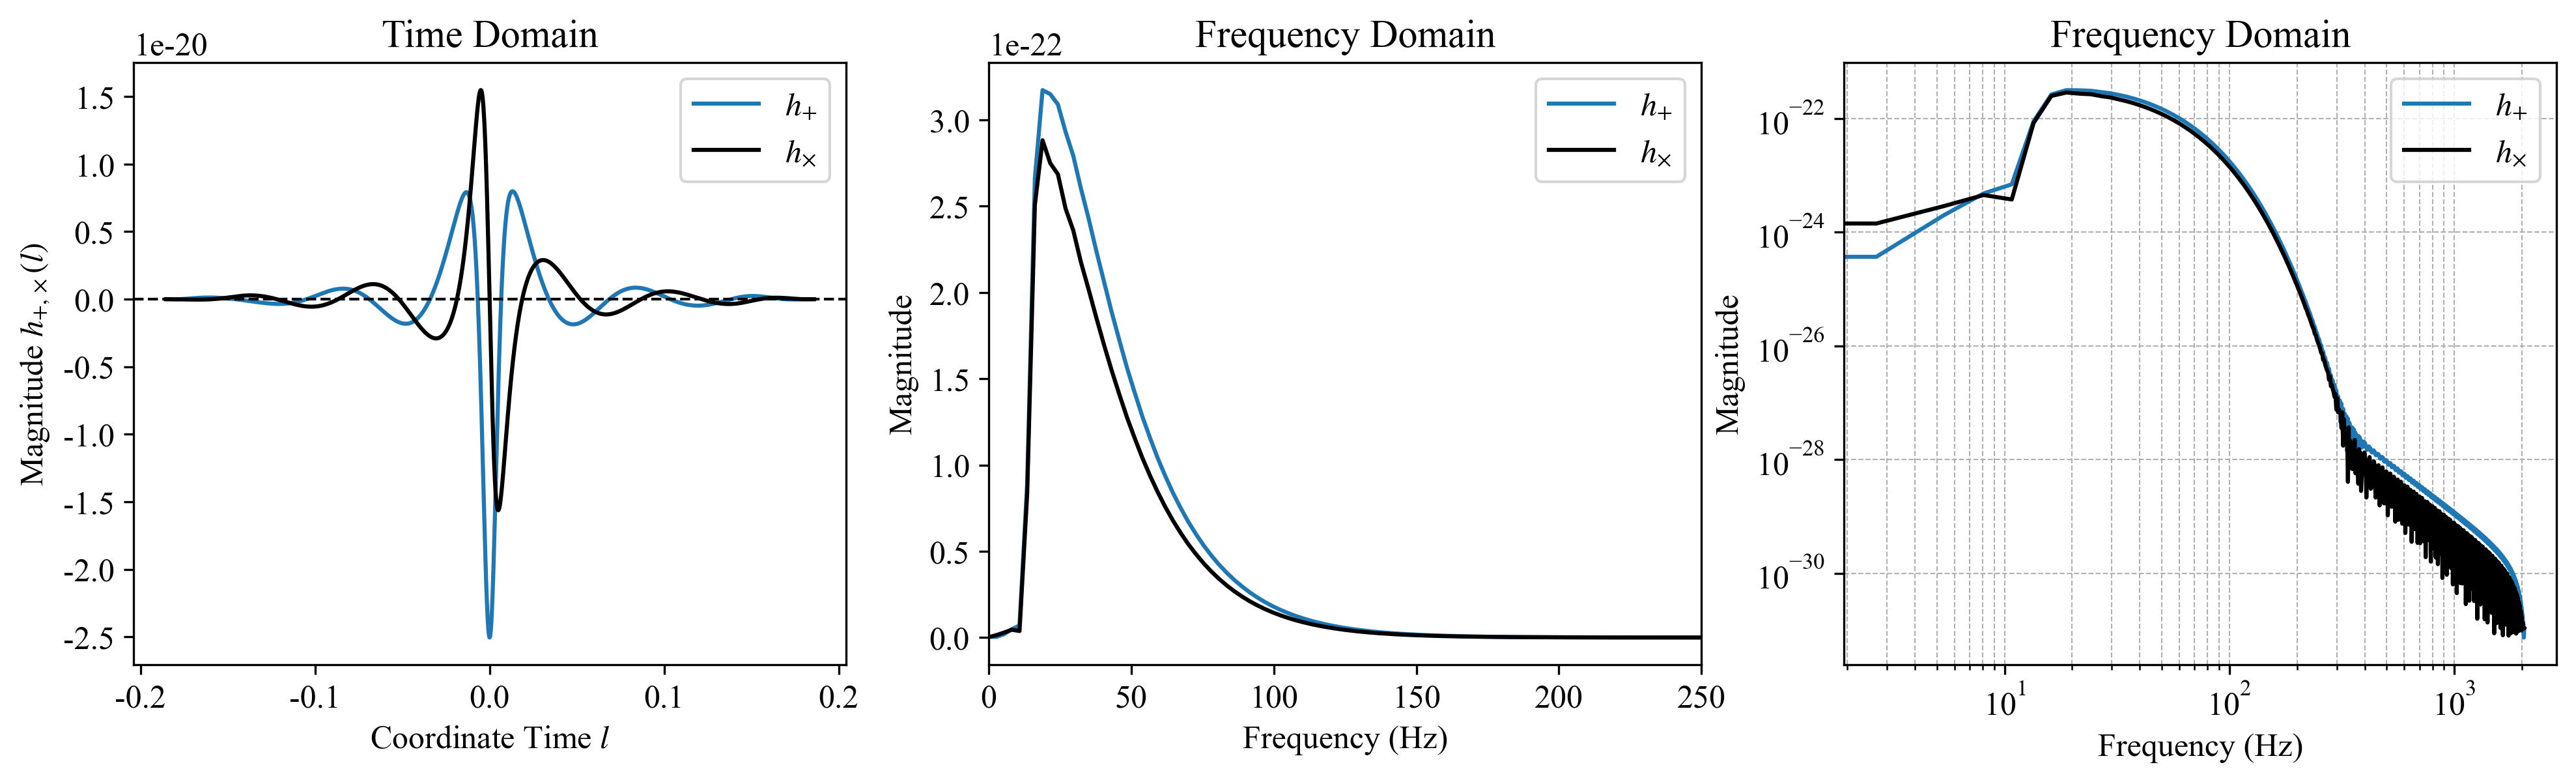

In [24]:
plt.figure(figsize=(16, 4), dpi =300)

plt.subplot(1, 3, 1)
plt.plot(t_coordinate, amplitude, label=r"$h_{+}$")
plt.plot(hc_ts.sample_times, hc_ts, color = "black", label=r"$h_{\times}$")
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{+,\times}(l)$")
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.title("Time Domain")
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hp_f.sample_frequencies, abs(hp_f), label=r"$h_{+}$")
plt.plot(hc_f.sample_frequencies, abs(hc_f), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.xlim(0, 250)
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(hp_f.sample_frequencies, abs(hp_f), label=r"$h_{+}$")
plt.loglog(hc_f.sample_frequencies, abs(hc_f), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

### highpass filter

In [26]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd.analytical import EinsteinTelescopeP1600143
from pycbc.noise import noise_from_psd
from pycbc.filter import matched_filter
from pycbc.filter import highpass

hp_ts_fir = highpass(hp_ts, 10.0)
hc_ts_fir = highpass(hc_ts, 10.0)
hp_fs_fir = FrequencySeries(np.zeros(len(hp_ts_fir)//2 + 1, dtype=np.complex128), delta_f=1.0/hp_ts_fir.duration)
hc_fs_fir = FrequencySeries(np.zeros(len(hc_ts_fir)//2 + 1, dtype=np.complex128), delta_f=1.0/hc_ts_fir.duration)
fft(hp_ts_fir, hp_fs_fir)
fft(hc_ts_fir, hc_fs_fir)

#print(len(hp_ts), len(hp_ts_fir), len(hp_fs_fir))

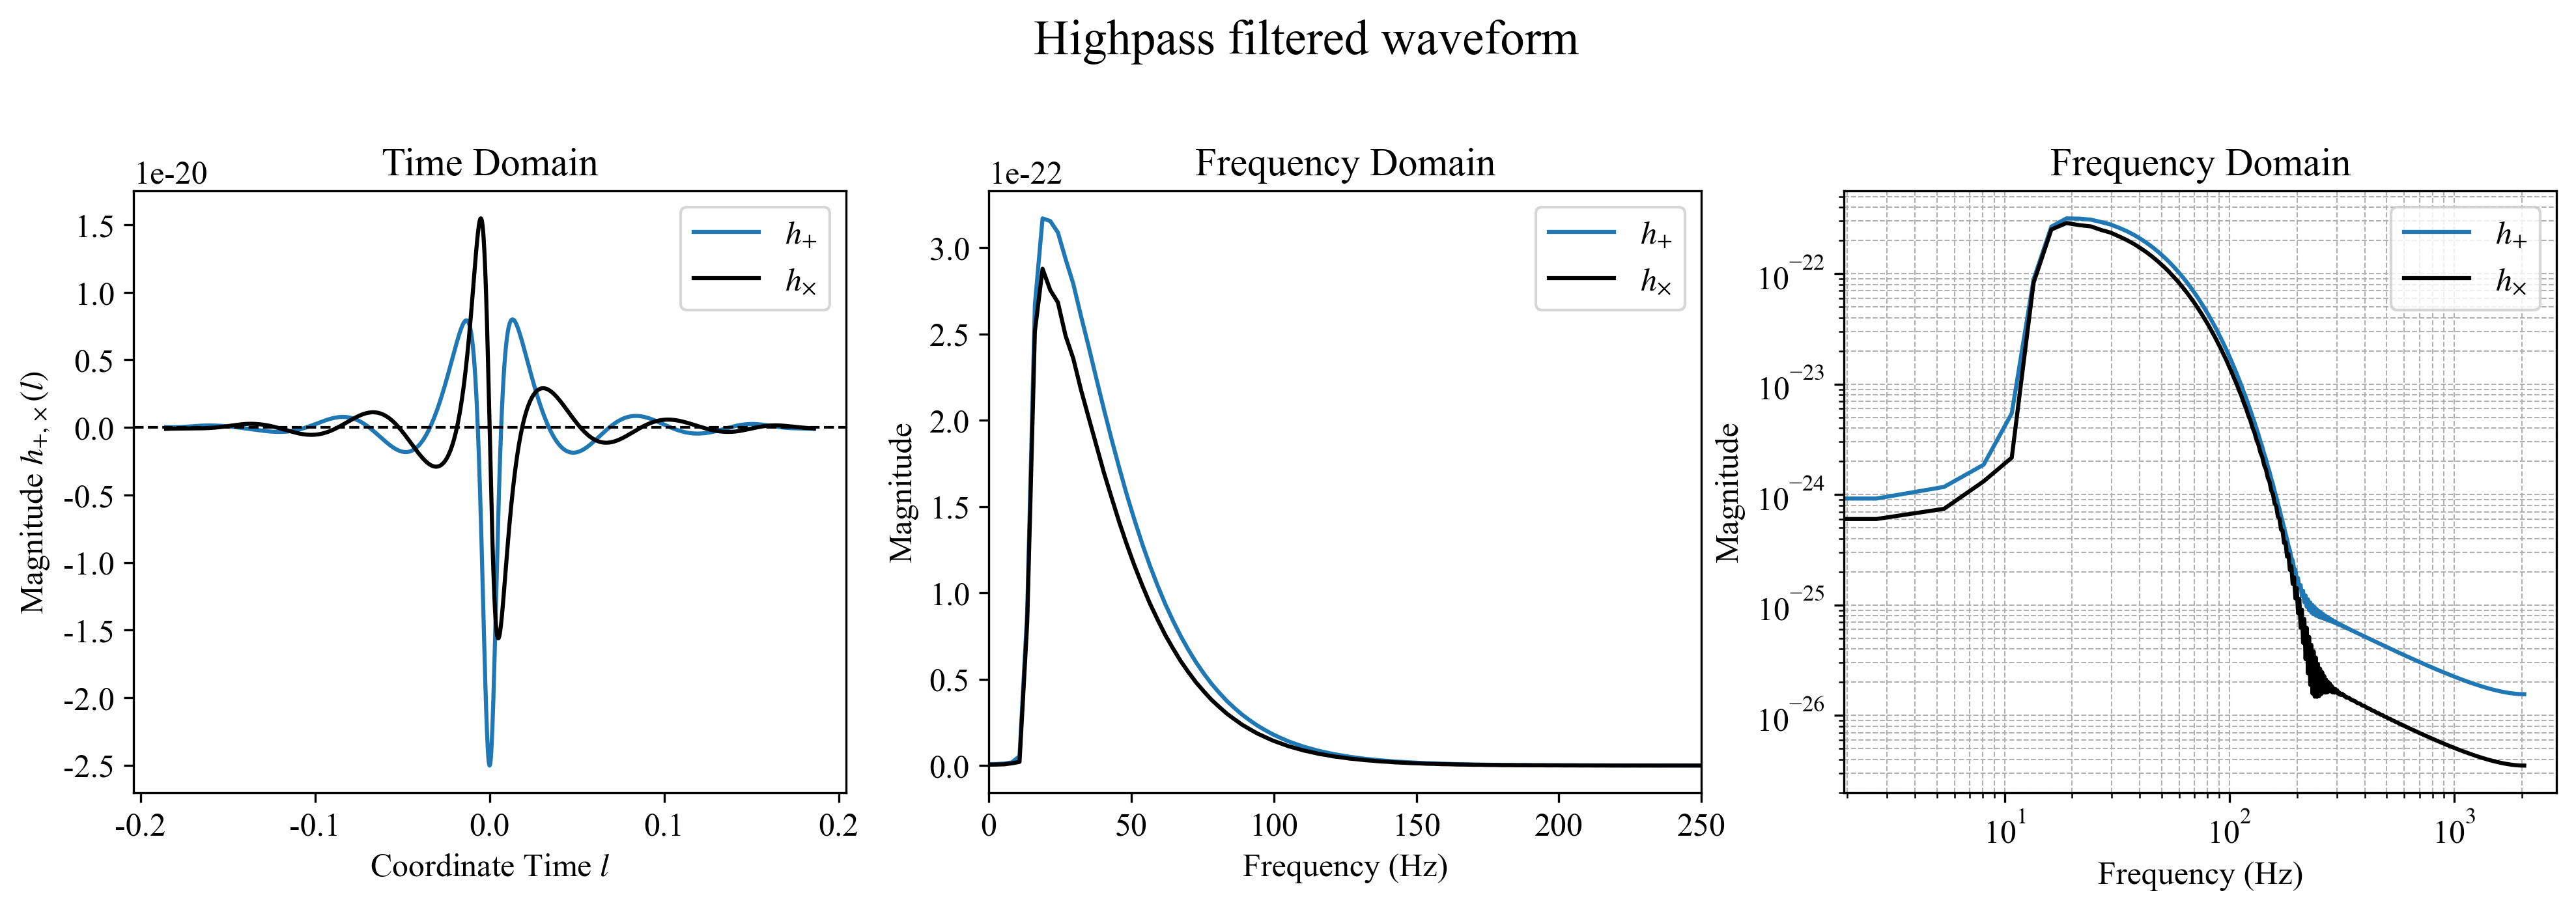

In [28]:
plt.figure(figsize=(16, 4), dpi =300)

plt.subplot(1, 3, 1)
plt.plot(hp_ts_fir.sample_times, hp_ts_fir, label=r"$h_{+}$")
plt.plot(hc_ts_fir.sample_times, hc_ts_fir, color = "black", label=r"$h_{\times}$")
plt.xlabel(r"Coordinate Time $l$")
plt.ylabel(r"Magnitude $h_{+,\times}(l)$")
plt.axhline(0, color='black', linestyle='--', linewidth=1.0)
plt.title("Time Domain")
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label=r"$h_{+}$")
plt.plot(hc_fs_fir.sample_frequencies, abs(hc_fs_fir), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.xlim(0, 250)
plt.grid(False)
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label=r"$h_{+}$")
plt.loglog(hc_fs_fir.sample_frequencies, abs(hc_fs_fir), color = "black", label=r"$h_{\times}$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Domain")
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.suptitle("Highpass filtered waveform", fontsize=18, y=1.1)
plt.show()

### generate noise

based on the filtered time series waveform

In [30]:
psd = aLIGOZeroDetHighPower(len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, low_freq_cutoff=10.0)
print(len(hp_ts_fir))
noise = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd, seed=333)
noise_ts = TimeSeries(noise.data, delta_t=noise.delta_t, epoch=hp_ts_fir.start_time)
noise_fs = noise_ts.to_frequencyseries()
signal_ts = hp_ts_fir + noise_ts
signal_fs = hp_fs_fir + noise_fs

1521


In [32]:
psd_et = pycbc.psd.from_txt('ET_D_sum_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
noise_et = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd_et, seed=333)
noise_et_ts = TimeSeries(noise_et.data, delta_t=noise_et.delta_t, epoch=hp_ts_fir.start_time)
noise_et_fs = noise_et_ts.to_frequencyseries()
signal_et_ts = hp_ts_fir + noise_et_ts
signal_et_fs = hp_fs_fir + noise_et_fs

In [34]:
psd_ce = pycbc.psd.from_txt('CE_2_psd.txt', len(hp_fs_fir), delta_f=hp_fs_fir.delta_f, 
                            low_freq_cutoff=10.0, is_asd_file=True)
noise_ce = noise_from_psd(len(hp_ts_fir), hp_ts_fir.delta_t, psd_ce, seed=333)
noise_ce_ts = TimeSeries(noise_ce.data, delta_t=noise_ce.delta_t, epoch=hp_ts_fir.start_time)
noise_ce_fs = noise_ce_ts.to_frequencyseries()
signal_ce_ts = hp_ts_fir + noise_ce_ts
signal_ce_fs = hp_fs_fir + noise_ce_fs

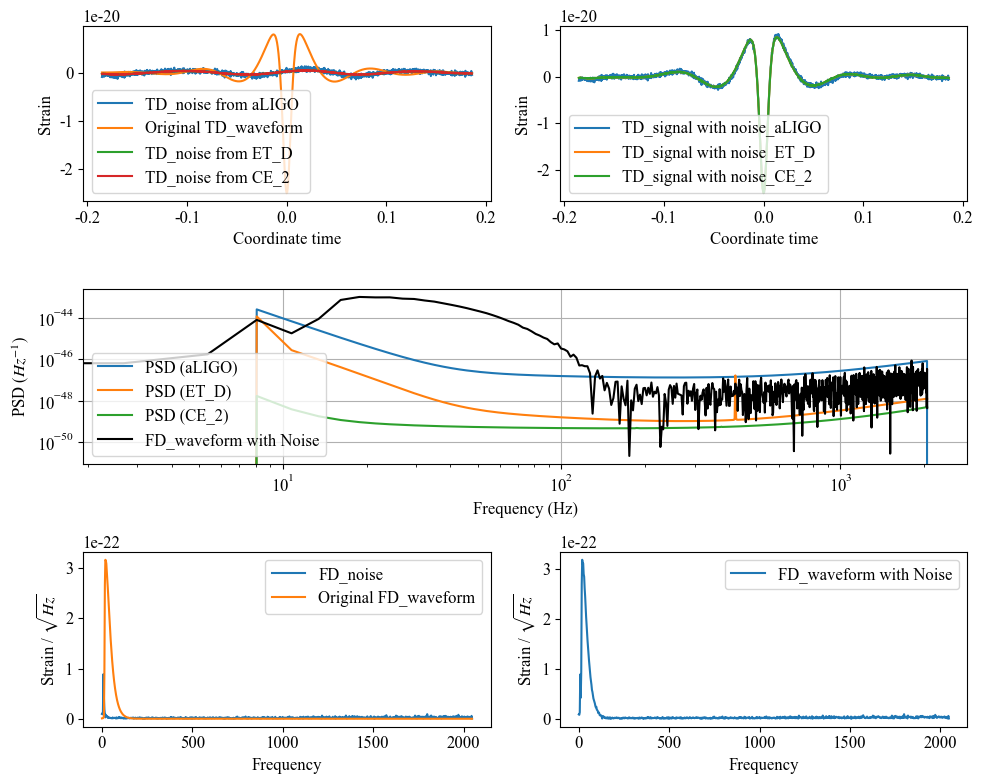

In [36]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
plt.plot(noise_ts.sample_times, noise_ts, label="TD_noise from aLIGO")
plt.plot(hp_ts_fir.sample_times, hp_ts_fir, label="Original TD_waveform")
plt.plot(noise_et_ts.sample_times, noise_et_ts, label="TD_noise from ET_D")
plt.plot(noise_et_ts.sample_times, noise_et_ts, label="TD_noise from CE_2")
plt.xlabel('Coordinate time')
plt.ylabel('Strain')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(signal_ts.sample_times, signal_ts, label="TD_signal with noise_aLIGO")
plt.plot(signal_et_ts.sample_times, signal_et_ts, label="TD_signal with noise_ET_D")
plt.plot(signal_et_ts.sample_times, signal_et_ts, label="TD_signal with noise_CE_2")
plt.xlabel('Coordinate time')
plt.ylabel('Strain')
plt.legend()

plt.subplot(3, 1, 2)
plt.loglog(psd.sample_frequencies, psd, label='PSD (aLIGO)')
plt.loglog(psd_et.sample_frequencies, psd_et, label='PSD (ET_D)')
plt.loglog(psd_ce.sample_frequencies, psd_ce, label='PSD (CE_2)')
plt.loglog(signal_fs.sample_frequencies, abs(signal_fs)**2, color = "black", label="FD_waveform with Noise")
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ($Hz^{-1}$)')
plt.legend()
plt.minorticks_on()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(noise_fs.sample_frequencies, abs(noise_fs), label="FD_noise")
plt.plot(hp_fs_fir.sample_frequencies, abs(hp_fs_fir), label="Original FD_waveform")
plt.xlabel('Frequency')
plt.ylabel(r'Strain / $\sqrt{Hz}$ ')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(signal_fs.sample_frequencies, abs(signal_fs), label="FD_waveform with Noise")
plt.xlabel('Frequency')
plt.ylabel(r'Strain / $\sqrt{Hz}$')
plt.legend()

plt.tight_layout()
plt.savefig('waveform_strain.png', dpi=300, bbox_inches='tight')
plt.show()

### SNR 

In [38]:
signal_ts = hp_ts_fir + noise_ts
signal_fs = hp_fs_fir + noise_fs
snr = matched_filter(hp_fs_fir, signal_fs, psd=psd, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

signal_et_ts = hp_ts_fir + noise_et_ts
signal_et_fs = hp_fs_fir + noise_et_fs
snr = matched_filter(hp_fs_fir, signal_et_fs, psd=psd_et, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

signal_ce_ts = hp_ts_fir + noise_ce_ts
signal_ce_fs = hp_fs_fir + noise_ce_fs
snr = matched_filter(hp_fs_fir, signal_ce_fs, psd=psd_ce, low_frequency_cutoff=10.0)
max_snr = abs(snr).max()
print(max_snr)

404.8018489805843
3131.4943467385847
12433.626122420159


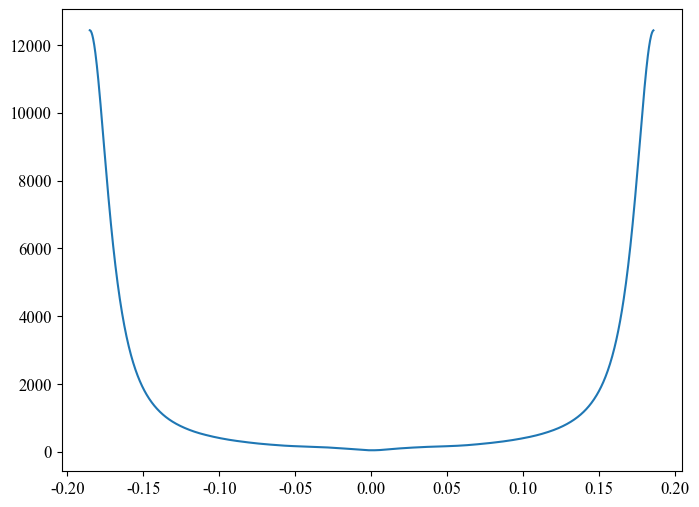

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(snr.sample_times, abs(snr))